In [1]:
# Jovian Commit Essentials
# Please retain and execute this cell without modifying the contents for `jovian.commit` to work
!pip install jovian --upgrade -q
import jovian
jovian.set_project('cars-classification')
jovian.set_colab_id('1jpPgI17wREgW9bccgfflyOH2OdMwE0U3')

# Stanford Car Classification 



## Imports

In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as tfs

from torchvision.datasets.utils import download_url
from torch.utils.data import random_split
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder

import os
import tarfile
import scipy.io
import cv2

## Download Data

### About Dataset 

16,185 images of 196 classes of cars. The data is split into 8,144 training images and 8,041 testing images, where each class has been split roughly in a 50-50 split. Classes are typically at the level of Make, Model, Year. , e.g. 2012 Tesla Model S or 2012 BMW M3 coupe.

This file gives documentation for the cars 196 dataset.
(http://ai.stanford.edu/~jkrause/cars/car_dataset.html)

 — — — — — — — — — — — — — — — — — — — — 

Metadata/Annotations

 — — — — — — — — — — — — — — — — — — — — 

Descriptions of the files are as follows:

-cars_meta.mat:

 Contains a cell array of class names, one for each class.

-cars_train_annos.mat:

 Contains the variable ‘annotations’, which is a struct array of length

 num_images and where each element has the fields:

 bbox_x1: Min x-value of the bounding box, in pixels

 bbox_x2: Max x-value of the bounding box, in pixels

 bbox_y1: Min y-value of the bounding box, in pixels
 
 bbox_y2: Max y-value of the bounding box, in pixels

 class: Integral id of the class the image belongs to.

 fname: Filename of the image within the folder of images.

-cars_test_annos.mat:

 Same format as ‘cars_train_annos.mat’, except the class is not provided.


 — — — — — — — — — — — — — — — — — — — — 

Submission file format

 — — — — — — — — — — — — — — — — — — — — 


Files for submission should be .txt files with the class prediction for
image M on line M. Note that image M corresponds to the Mth annotation in
the provided annotation file. An example of a file in this format is
train_perfect_preds.txt
Included in the devkit are a script for evaluating training accuracy,
eval_train.m. Usage is:
(in MATLAB)
>> [accuracy, confusion_matrix] = eval_train(‘train_perfect_preds.txt’)
If your training predictions work with this function then your testing
predictions should be good to go for the evaluation server, assuming
that they’re in the same format as your training predictions.

In [3]:
dataset_url = 'https://s3.amazonaws.com/fast-ai-imageclas/stanford-cars.tgz'

dataset = download_url(dataset_url, '.',)

Using downloaded and verified file: ./stanford-cars.tgz


In [4]:
with tarfile.open('./stanford-cars.tgz','r') as tar:
    tar.extractall(path='./data')

In [5]:
data_dir = './data/stanford-cars/'

In [6]:
os.listdir(data_dir)

['cars_train', 'cars_test', 'cars_annos.mat']

In [7]:
for i in ['cars_train', 'cars_test']:
    path = data_dir+i
    print(f"Length of {i} is {len(os.listdir(path))}")

Length of cars_train is 8144
Length of cars_test is 8041


In [8]:
cars_annos = scipy.io.loadmat(data_dir+'cars_annos.mat')

In [9]:
type(cars_annos)

dict

In [10]:
cars_annos.keys()

dict_keys(['__header__', '__version__', '__globals__', 'annotations', 'class_names'])

Our interest is 'annotations' key

In [11]:
cars_annos['annotations'].shape  , type(cars_annos['annotations'])

((1, 16185), numpy.ndarray)

In [12]:
cars_annos['annotations'][0][0]

(array(['car_ims/000001.jpg'], dtype='<U18'), array([[112]], dtype=uint8), array([[7]], dtype=uint8), array([[853]], dtype=uint16), array([[717]], dtype=uint16), array([[1]], dtype=uint8), array([[0]], dtype=uint8))

In [13]:
[item.flat[0] for item in cars_annos['annotations'][0][0]]

['car_ims/000001.jpg', 112, 7, 853, 717, 1, 0]

In [14]:
data = [[item.flat[0] for item in line] for line in cars_annos['annotations'][0]]

In [15]:
data[0]

['car_ims/000001.jpg', 112, 7, 853, 717, 1, 0]

In [16]:
cols = list(pd.DataFrame(cars_annos['annotations'][0]).columns)

In [17]:
cols

['relative_im_path',
 'bbox_x1',
 'bbox_y1',
 'bbox_x2',
 'bbox_y2',
 'class',
 'test']

In [18]:
cars_annotation = pd.DataFrame(data,columns=cols)

In [19]:
cars_annotation['image_name'] = cars_annotation['relative_im_path'].apply(lambda x: x.split('/0')[1])

In [141]:
# cars_annotation.drop('relative_im_path', axis=1,inplace=True)

In [28]:
cars_annotation[]

0        car_ims/000001.jpg
1        car_ims/000002.jpg
2        car_ims/000003.jpg
3        car_ims/000004.jpg
4        car_ims/000005.jpg
                ...        
16180    car_ims/016181.jpg
16181    car_ims/016182.jpg
16182    car_ims/016183.jpg
16183    car_ims/016184.jpg
16184    car_ims/016185.jpg
Name: relative_im_path, Length: 16185, dtype: object

Similarly convert load and convert classes

In [152]:
# cars_annos['class_names'][0]

In [151]:
car_classes = [item[0] for item in cars_annos['class_names'][0]]

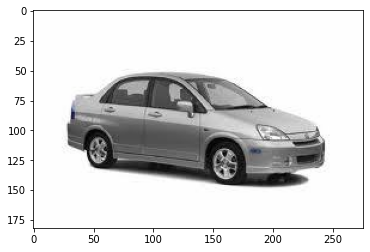

In [26]:
img = cv2.imread(data_dir+'cars_test/00001.jpg')
img.shape
plt.imshow(img)

In [162]:
car_classes[:10]

['AM General Hummer SUV 2000',
 'Acura RL Sedan 2012',
 'Acura TL Sedan 2012',
 'Acura TL Type-S 2008',
 'Acura TSX Sedan 2012',
 'Acura Integra Type R 2001',
 'Acura ZDX Hatchback 2012',
 'Aston Martin V8 Vantage Convertible 2012',
 'Aston Martin V8 Vantage Coupe 2012',
 'Aston Martin Virage Convertible 2012']

In [25]:
os.listdir(data_dir+'cars_train/')[480]

'00484.jpg'

In [24]:
os.listdir(data_dir+'cars_test/')[480]

'03462.jpg'

In [27]:
cars_annos

{'__globals__': [],
 '__header__': b'MATLAB 5.0 MAT-file, Platform: GLNXA64, Created on: Sat Feb 28 19:34:55 2015',
 '__version__': '1.0',
 'annotations': array([[(array(['car_ims/000001.jpg'], dtype='<U18'), array([[112]], dtype=uint8), array([[7]], dtype=uint8), array([[853]], dtype=uint16), array([[717]], dtype=uint16), array([[1]], dtype=uint8), array([[0]], dtype=uint8)),
         (array(['car_ims/000002.jpg'], dtype='<U18'), array([[48]], dtype=uint8), array([[24]], dtype=uint8), array([[441]], dtype=uint16), array([[202]], dtype=uint8), array([[1]], dtype=uint8), array([[0]], dtype=uint8)),
         (array(['car_ims/000003.jpg'], dtype='<U18'), array([[7]], dtype=uint8), array([[4]], dtype=uint8), array([[277]], dtype=uint16), array([[180]], dtype=uint8), array([[1]], dtype=uint8), array([[0]], dtype=uint8)),
         ...,
         (array(['car_ims/016183.jpg'], dtype='<U18'), array([[25]], dtype=uint8), array([[32]], dtype=uint8), array([[587]], dtype=uint16), array([[359]], dt

In [29]:
cars_annos['annotations']

16185

In [30]:
cars_annos['class_names']

196

# Commit your Progress

In [ ]:
!pip install jovian --upgrade --quiet

In [ ]:
import jovian

In [ ]:
# Execute this to save new versions of the notebook
jovian.commit(project="cars-classification")